In [1]:
import csv
import pandas as pd
import time


from models.ml_basic_inference import predict_custom_input

dataset_dir = 'dataset_IHT/'

/Users/s5068337/Documents/GitHub/core-temperature-modelling/.venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.0.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
# Read the CSV file
df = pd.read_csv(dataset_dir + 'sensor.csv')
demographics_df = pd.read_csv(dataset_dir + 'demographics.csv')

# Filter out anyone not in demographics file
filtered_df = pd.merge(df, demographics_df[['userId']], on='userId', how='inner')

# Sample 6% of the data
sampled_df = filtered_df.sample(frac=0.08)

# Save the sampled data to a new CSV file
sampled_df.to_csv(dataset_dir + 'sampled_sensor.csv', index=False)

# Clear memory
df = None
sampled_df = None
demographics_df = None
filtered_df = None

In [9]:
def process_data():
    dataset_dir = 'dataset_IHT/'
    # Read demographics data
    demographics = pd.read_csv(dataset_dir + 'demographics.csv')
    demographics['userId'] = demographics['userId'].astype(int)
    demographics.set_index('userId', inplace=True)

    # Find total rows
    total_rows = sum(1 for _ in open(dataset_dir + 'sampled_sensor.csv')) - 1  # Subtract 1 for header
    processed_rows = 0
    start_time = time.time()

    # Read and process sensor data
    with open(dataset_dir + 'sampled_sensor.csv', 'r') as input_file, \
         open(dataset_dir + 'processed_sensor.csv', 'w', newline='') as output_file:

        reader = csv.DictReader(input_file)
        fieldnames = reader.fieldnames + ['ml_final_tre', 'ml_final_mtsk', 'ml_initial_tre', 'ml_initial_mtsk', 'ml_core_delta']
        writer = csv.DictWriter(output_file, fieldnames=fieldnames)
        writer.writeheader()

        for row in reader:
            processed_rows += 1
            if processed_rows % 1000 == 0:
                elapsed_time = time.time() - start_time
                progress = processed_rows / total_rows
                estimated_total_time = elapsed_time / progress
                estimated_remaining_time = estimated_total_time - elapsed_time
                print(f"Processed {processed_rows} of {total_rows} rows ({progress:.2%})")
                print(f"Estimated time remaining: {estimated_remaining_time/60:.2f} minutes")

            userId = int(row['userId'])
            if userId in demographics.index:
                user_data = demographics.loc[userId]
                female = int(user_data['female'])  # Convert to int (0 or 1)
                age = user_data['age']
                height = user_data['height']
                mass = user_data['mass']
                ta_set = float(row['temperature'])
                rh_set = float(row['humidity'])

                final_tre, final_mtsk, initial_tre, initial_mtsk = predict_custom_input(female, age, height, mass, ta_set, rh_set)

                row['ml_final_tre'] = final_tre
                row['ml_final_mtsk'] = final_mtsk
                row['ml_initial_tre'] = initial_tre
                row['ml_initial_mtsk'] = initial_mtsk
                row['ml_core_delta'] = final_tre - initial_tre
            else:
                # Handle case where userId is not in demographics data
                print('UNABLE TO FIND USERID:', userId)
                continue

            writer.writerow(row)

In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
process_data()

Processed 1000 of 309246 rows (0.32%)
Estimated time remaining: 172.70 minutes
Processed 2000 of 309246 rows (0.65%)
Estimated time remaining: 172.70 minutes
Processed 3000 of 309246 rows (0.97%)
Estimated time remaining: 172.11 minutes
Processed 4000 of 309246 rows (1.29%)
Estimated time remaining: 171.32 minutes
Processed 5000 of 309246 rows (1.62%)
Estimated time remaining: 169.47 minutes
Processed 6000 of 309246 rows (1.94%)
Estimated time remaining: 168.05 minutes
Processed 7000 of 309246 rows (2.26%)
Estimated time remaining: 167.09 minutes
Processed 8000 of 309246 rows (2.59%)
Estimated time remaining: 165.97 minutes
Processed 9000 of 309246 rows (2.91%)
Estimated time remaining: 164.86 minutes
Processed 10000 of 309246 rows (3.23%)
Estimated time remaining: 163.94 minutes
Processed 11000 of 309246 rows (3.56%)
Estimated time remaining: 163.24 minutes
Processed 12000 of 309246 rows (3.88%)
Estimated time remaining: 162.41 minutes
Processed 13000 of 309246 rows (4.20%)
Estimated 

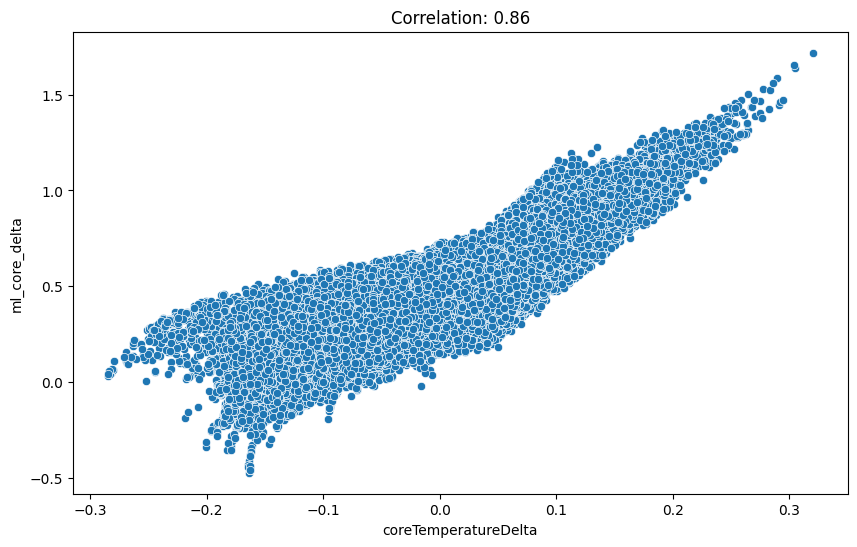

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv(dataset_dir + 'processed_sensor.csv')

# Calculate the correlation
correlation = df['coreTemperatureDelta'].corr(df['ml_core_delta'])

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='coreTemperatureDelta', y='ml_core_delta', data=df)
plt.title(f'Correlation: {correlation:.2f}')
plt.show()

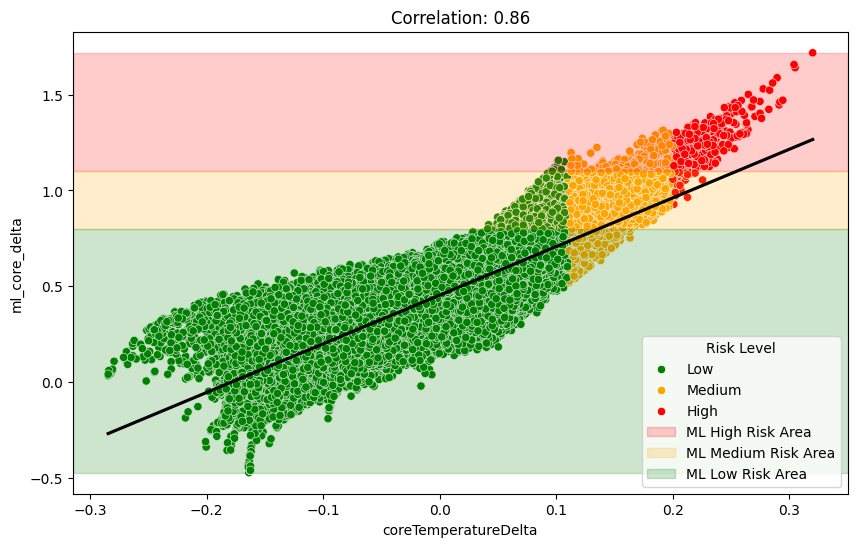

Counts of risk levels based on coreTemperatureDelta:
risk_level
Low       280642
Medium     28100
High         504
Name: count, dtype: int64

Counts of risk levels based on ml_core_delta:
ml_risk_level
Low       276753
Medium     31298
High        1195
Name: count, dtype: int64

Number of disagreements between the models:
18089/308867 (0.06%)


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the risk levels
class RiskLevel:
    HIGH = 'High'
    MEDIUM = 'Medium'
    LOW = 'Low'

ml_med_threshold = 0.8
ml_high_threshold = 1.1

# Function to determine the risk level for coreTemperatureDelta
def determine_risk_level(coreTemperatureDelta):
    if coreTemperatureDelta >= 0.2:
        return RiskLevel.HIGH
    elif coreTemperatureDelta >= 0.11:
        return RiskLevel.MEDIUM
    else:
        return RiskLevel.LOW

# Function to determine the risk level for ml_core_delta
def determine_ml_risk_level(ml_core_delta):
    if ml_core_delta >= ml_high_threshold:
        return RiskLevel.HIGH
    elif ml_core_delta >= ml_med_threshold:
        return RiskLevel.MEDIUM
    else:
        return RiskLevel.LOW

# Read the CSV file
df = pd.read_csv(dataset_dir + 'processed_sensor.csv')
# Filter out values that are negative on both axes
# df = df[~((df['coreTemperatureDelta'] < 0) | (df['ml_core_delta'] < 0))]

# Apply the functions to create new columns 'risk_level' and 'ml_risk_level'
df['risk_level'] = df['coreTemperatureDelta'].apply(determine_risk_level)
df['ml_risk_level'] = df['ml_core_delta'].apply(determine_ml_risk_level)

# Calculate the correlation
correlation = df['coreTemperatureDelta'].corr(df['ml_core_delta'])

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='coreTemperatureDelta', y='ml_core_delta', hue='risk_level', palette={'High': 'red', 'Medium': 'orange', 'Low': 'green'}, data=df)

sns.regplot(x='coreTemperatureDelta', y='ml_core_delta', data=df, scatter=False, color='black')

# Add shaded areas
plt.axhspan(ml_high_threshold, df['ml_core_delta'].max(), color='red', alpha=0.2, label='ML High Risk Area')
plt.axhspan(ml_med_threshold, ml_high_threshold, color='orange', alpha=0.2, label='ML Medium Risk Area')
plt.axhspan(df['ml_core_delta'].min(), ml_med_threshold, color='green', alpha=0.2, label='ML Low Risk Area')

plt.title(f'Correlation: {correlation:.2f}')

plt.title(f'Correlation: {correlation:.2f}')
plt.legend(title='Risk Level')
plt.show()

# Count the occurrences of each risk level
core_temp_counts = df['risk_level'].value_counts()
ml_core_counts = df['ml_risk_level'].value_counts()

# Display the counts
print("Counts of risk levels based on coreTemperatureDelta:")
print(core_temp_counts)

print("\nCounts of risk levels based on ml_core_delta:")
print(ml_core_counts)

# Count the number of disagreements between the models
df['disagreement'] = df['risk_level'] != df['ml_risk_level']
disagreement_count = df['disagreement'].sum()

# Display the number of disagreements
print("\nNumber of disagreements between the models:")
print('{}/{} ({:.2f}%)'.format(disagreement_count, df['coreTemperatureDelta'].count(), disagreement_count/df['coreTemperatureDelta'].count()))


In [16]:
import numpy as np
import scipy.stats as stats

# Calculate the differences
diff = df['ml_core_delta'] - df['coreTemperatureDelta']

# Calculate the mean difference and standard deviation of differences
mean_diff = np.mean(diff)
std_diff = np.std(diff, ddof=1)

# Calculate the 95% limits of agreement
lower_limit = mean_diff - 1.96 * std_diff
upper_limit = mean_diff + 1.96 * std_diff

# Print the results
print(f"Mean difference: {mean_diff:.3f}")
print(f"Standard deviation of differences: {std_diff:.3f}")
print(f"95% Limits of Agreement: ({lower_limit:.3f}, {upper_limit:.3f})")

# Calculate the percentage of points within the limits of agreement
within_limits = ((diff >= lower_limit) & (diff <= upper_limit)).sum()
percentage_within = (within_limits / len(diff)) * 100

print(f"Percentage of points within limits of agreement: {percentage_within:.2f}%")

# Perform paired t-test
t_statistic, p_value = stats.ttest_rel(df['ml_core_delta'], df['coreTemperatureDelta'])
print(f"Paired t-test p-value: {p_value:.4f}")

Mean difference: 0.513
Standard deviation of differences: 0.146
95% Limits of Agreement: (0.226, 0.800)
Percentage of points within limits of agreement: 94.46%
Paired t-test p-value: nan
